# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 3rd 2025

**Student Name**: Ana Carolina Arellano Valdez

**Professor**: Pablo Camarillo Ramirez

# Dataset description

## About the dataset
The dataset used is a collection of the Vienna subway's network data. Columns contain the stations, the lines and their color. In the rows, the connections between stations are recorded.

The **start** column indicates the source, and the **stop** column indicates the destination.

Here's the link to the dataset: https://www.kaggle.com/datasets/lenapiter/vienna-subway-network

# Data ingestion

In [40]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

spark.conf.set("spark.sql.shuffle.partitions", "5")

In [41]:
# Build schema
# Import your module
from carolinarellano.spark_utils import SparkUtils

vienna_schema_columns = [("start", "string"), 
                         ("stop", "string"), 
                         ("line", "int"), 
                         ("color", "string")]

vienna_schema = SparkUtils.generate_schema(vienna_schema_columns)

base_path = "/opt/spark/work-dir/data/"
vienna_df = spark.read \
                .option("header", "true") \
                .schema(vienna_schema) \
                .csv(base_path + "/vienna_subway.csv", sep=";")



# Transformations

In [42]:
# Add the code for your transformations to create nodes and edges DataFrames HERE
from pyspark.sql.functions import col, lit

# Nodes
# Start stations -> source
start_nodes = vienna_df.select(col("start").alias("name")).distinct()
# Stop stations -> destination
stop_nodes = vienna_df.select(col("stop").alias("name")).distinct()

# Edges
routes_edges = vienna_df.select(
    col("start").alias("source"), 
    col("stop").alias("destination"), 
    col("line"), 
    col("color")
)



# Writing Data in Neo4j

In [43]:
# Add the code to write a graph from PySpark's DataFrames to Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

start_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Start") \
  .option("node.keys", "name") \
  .save()

print(f"{start_nodes.count()} start stations wrote in Neo4j")

stop_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Stop") \
  .option("node.keys", "name") \
  .save()

print(f"{stop_nodes.count()} stop stations wrote in Neo4j")

routes_edges.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "ROUTE") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Start") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "source:name") \
  .option("relationship.target.labels", ":Stop") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "destination:name") \
  .save()

print(f"{routes_edges.count()} routes wrote in Neo4j")


94 start stations wrote in Neo4j
93 stop stations wrote in Neo4j
93 stop stations wrote in Neo4j
104 routes wrote in Neo4j
104 routes wrote in Neo4j


# Read and Query Graphs with PySpark

In [47]:
# Add the code to read a data frame from Neo4J and run a simple query to verify 
cypher_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            MATCH (s:Start)-[r:ROUTE]->(d:Stop)
            WHERE r.color = 'purple'
            RETURN s.name AS start_station, 
                   d.name AS stop_station,
                   r.line, r.color AS route_color
            """) \
    .load()

cypher_df.show()

+-----------------+-----------------+------+-----------+
|    start_station|     stop_station|r.line|route_color|
+-----------------+-----------------+------+-----------+
|  Museumsquartier|       Karlsplatz|     2|     purple|
|         Seestadt|      Aspern Nord|     2|     purple|
|          Stadlau|Donaustadtbruecke|     2|     purple|
|      Praterstern|     Taborstrasse|     2|     purple|
|     Volkstheater|  Museumsquartier|     2|     purple|
|    Aspernstrasse|      Donauspital|     2|     purple|
|      Donaumarina|          Stadion|     2|     purple|
|     Taborstrasse|     Schottenring|     2|     purple|
|      Aspern Nord|  Hausfeldstrasse|     2|     purple|
|Donaustadtbruecke|      Donaumarina|     2|     purple|
|      Hardeggasse|          Stadlau|     2|     purple|
|      Schottentor|          Rathaus|     2|     purple|
|          Rathaus|     Volkstheater|     2|     purple|
|     Messe-Prater|      Praterstern|     2|     purple|
|  Hausfeldstrasse|    Aspernst

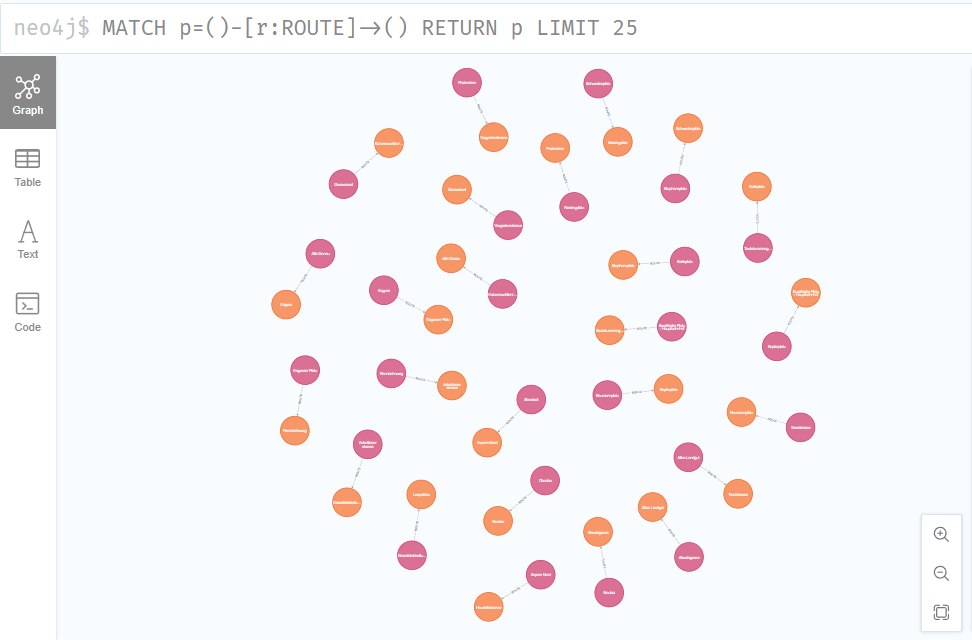

In [38]:
sc.stop()